In [ ]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import yfinance as yf


from tcn import TCN

#**Pre-processing**

In [ ]:
# We define the methods to calculate technical indicators
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset


# Get the dataset with the indicator we want
def get_dataset(ticker, start_date_str, end_date_str, features):
  yf.pdr_override()  #This step is very important
  start_date = dt.strptime(start_date_str, '%m/%d/%y')
  end_date = dt.strptime(end_date_str, '%m/%d/%y')
  df_raw = pdr.get_data_yahoo(ticker, start_date, end_date)
  df_basic = df_raw[['Close', 'Volume']]
  df_basic.columns = ['Price', 'Volume']
  df_indicators = get_technical_indicators(df_basic)
  df_indicators = df_indicators.dropna()
  df = df_indicators[features]
  return df


# Get datasets for train and test
def get_train_test_dataset(df, split):
  training_data_len = math.ceil(len(df) * split)
  train_df = df[:training_data_len]
  test_df = df[training_data_len:]
  return train_df, test_df


# get x_train and y_train with normalization
def get_x_y_train(train_df, sequence_length):
  scalar = MinMaxScaler()
  train_df_x = train_df
  train_df_y = train_df[['Price']][sequence_length:]
  # Dealing with x_train
  train_df_x_scaled = scalar.fit_transform(train_df_x)
  x_train = []
  for i in range(sequence_length, train_df_x.shape[0]):
    x_train.append(train_df_x_scaled[i-sequence_length: i])
  x_train = np.array(x_train)
  # Dealing with y_train
  train_df_y_scaled = scalar.fit_transform(train_df_y)
  y_train = np.squeeze(train_df_y_scaled)
  return x_train, y_train


# get x_test and y_test
def get_x_y_test(test_df, sequence_length):
  scalar = MinMaxScaler()
  test_df_x = test_df
  test_df_y = test_df[['Price']][sequence_length:]
  # Dealing with x_test
  test_df_x_scaled = scalar.fit_transform(test_df_x)
  x_test = []
  for i in range(sequence_length, test_df_x.shape[0]):
    x_test.append(test_df_x_scaled[i-sequence_length: i])
  x_test = np.array(x_test)
  # Dealing with y_test
  test_df_y_scaled = scalar.fit_transform(test_df_y)
  y_test = np.squeeze(test_df_y_scaled)
  return x_test, y_test, test_df_y

In [ ]:
ticker = "SPY" # ticker name
start_date_str = "01/01/98"
end_date_str = "05/14/23"
features = ['Price','momentum'] # The indicators we choose 'Closed Price' and 'Momentum'
sequence_length = 50 # time steps for LSTM
df = get_dataset(ticker, start_date_str, end_date_str, features)
split = 0.8 # split ratio for training and test sets
train_df, test_df = get_train_test_dataset(df, split)
# x_train, y_train, x_test, y_test, test_df_y are five important datasets
x_train, y_train = get_x_y_train(train_df, sequence_length)
x_test, y_test, test_df_y = get_x_y_test(test_df, sequence_length)

[*********************100%***********************]  1 of 1 completed


<ipython-input-10-fddec01f9823>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
<ipython-input-10-fddec01f9823>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
<ipython-input-10-fddec01f9823>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

#**Model Settup**

In [ ]:
# Note I used three ways to build Deep Learning models with Keras
# All of them are feasiable

#Potential values "LSTM" or "TCN"
models = ["LSTM", "TCN", "GRU", "SimpleRNN"]
model_selection = models[2]

model = Sequential()

if model_selection == "LSTM":
    model.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 60, activation = 'tanh', return_sequences = True))
    model.add(Dropout(0.3))

    model.add(LSTM(units = 80, activation = 'tanh', return_sequences = True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 120, activation = 'tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(units = 1))

elif model_selection == "TCN":
  model = Sequential(
    layers=[
        TCN(input_shape=(sequence_length, len(features)),
            nb_filters = 5,
            padding = "causal",
            kernel_size = 5,
            dilations=[1, 2, 4,8,16]
            ),          
        Dense(1)  # output.shape = (batch, output_timesteps, output_dim)
      ]
    ) 
    

elif model_selection == "GRU":
  inputs  = keras.Input(shape = (sequence_length,len(features)))
  x = layers.GRU(32,recurrent_dropout = 0, return_sequences = True)(inputs)
  x = layers.GRU(32,recurrent_dropout=0)(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs,outputs)
  
elif model_selection == "SimpleRNN":
  inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
  x = SimpleRNN(16, return_sequences=True)(inputs)
  x = SimpleRNN(16)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 2)]           0         
                                                                 
 gru_2 (GRU)                 (None, 50, 32)            3456      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,825
Trainable params: 9,825
Non-trainable params: 0
_________________________________________________________________


#**Model Training and Plotting loss/MAE**


In [ ]:
# Compile and fit Model
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0003),
              metrics=['mae']) #mae
history = model.fit(x_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
79/79 [==============================] - 7s 40ms/step - loss: 0.0105 - mae: 0.0709
Epoch 2/50
79/79 [==============================] - 3s 39ms/step - loss: 0.0065 - mae: 0.0552
Epoch 3/50
79/79 [==============================] - 3s 39ms/step - loss: 0.0053 - mae: 0.0506
Epoch 4/50
79/79 [==============================] - 3s 39ms/step - loss: 0.0046 - mae: 0.0473
Epoch 5/50
79/79 [==============================] - 3s 37ms/step - loss: 0.0046 - mae: 0.0467
Epoch 6/50
79/79 [==============================] - 3s 37ms/step - loss: 0.0041 - mae: 0.0434
Epoch 7/50
79/79 [==============================] - 3s 37ms/step - loss: 0.0042 - mae: 0.0432
Epoch 8/50
79/79 [==============================] - 3s 39ms/step - loss: 0.0038 - mae: 0.0413
Epoch 9/50
79/79 [==============================] - 3s 37ms/step - loss: 0.0034 - mae: 0.0388
Epoch 10/50
79/79 [==============================] - 3s 38ms/step - loss: 0.0033 - mae: 0.0375
Epoch 11/50
79/79 [==============================] - 3s 38m

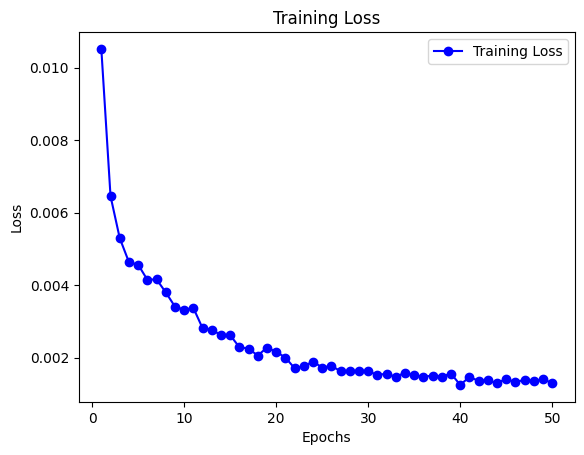

In [ ]:
# Plot Loss on each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plot the training loss
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

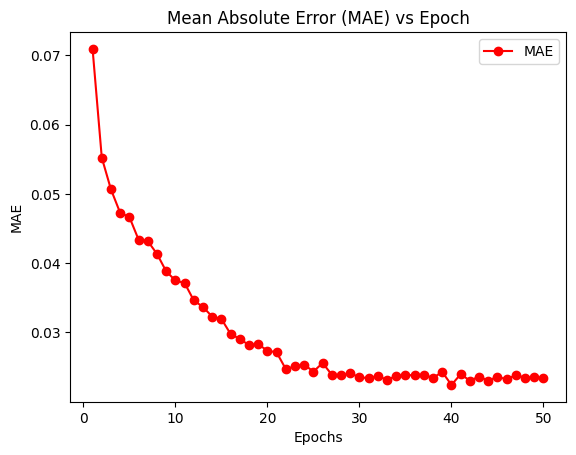

In [ ]:
# Plot MAE on each epoch
mae = history.history['mae']
epochs = range(1, len(mae) + 1)

# Let's plot with MAE different colors
plt.plot(epochs, mae, 'ro-', label='MAE')
plt.title('Mean Absolute Error (MAE) vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#**Evaluation**

In [ ]:
# get final y_test and y_pred after denormalization
def get_final_y_test_pred(test_df_y, y_pred):
  scalar = MinMaxScaler()
  scalar.fit_transform(test_df_y)
  y_pred_denormalized = scalar.inverse_transform(y_pred)
  final_y_test = np.array(test_df_y['Price'].tolist())
  final_y_pred = np.squeeze(y_pred_denormalized)
  return final_y_test, final_y_pred

In [ ]:
y_pred = model.predict(x_test)
final_y_test, final_y_pred = get_final_y_test_pred(test_df_y, y_pred)

39/39 [==============================] - 1s 8ms/step


### Model Evaluation

Mean absolute percentage error

In [ ]:
# Calculate Mean absolute Percentage Error
loss = keras.losses.mean_absolute_percentage_error(final_y_test, final_y_pred)
print("Mean absolute percentage error between true and prediction :{0:.3f}%".format(loss))

Mean absolute percentage error between true and prediction :1.232%


Mean Absolute Error

In [ ]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(final_y_test, final_y_pred)
print("Mean absolute error between true and prediction :{0:.3f}".format(mae))

Mean absolute error between true and prediction :4.479


Correlation

In [ ]:
# Correlation between predicted stock prices and real stock prices
corr = pd.Series(final_y_test).corr(pd.Series(final_y_pred))
print("Correlation between true and prediction:{0:.3f}".format(corr))

Correlation between true and prediction:0.997


### Visualization

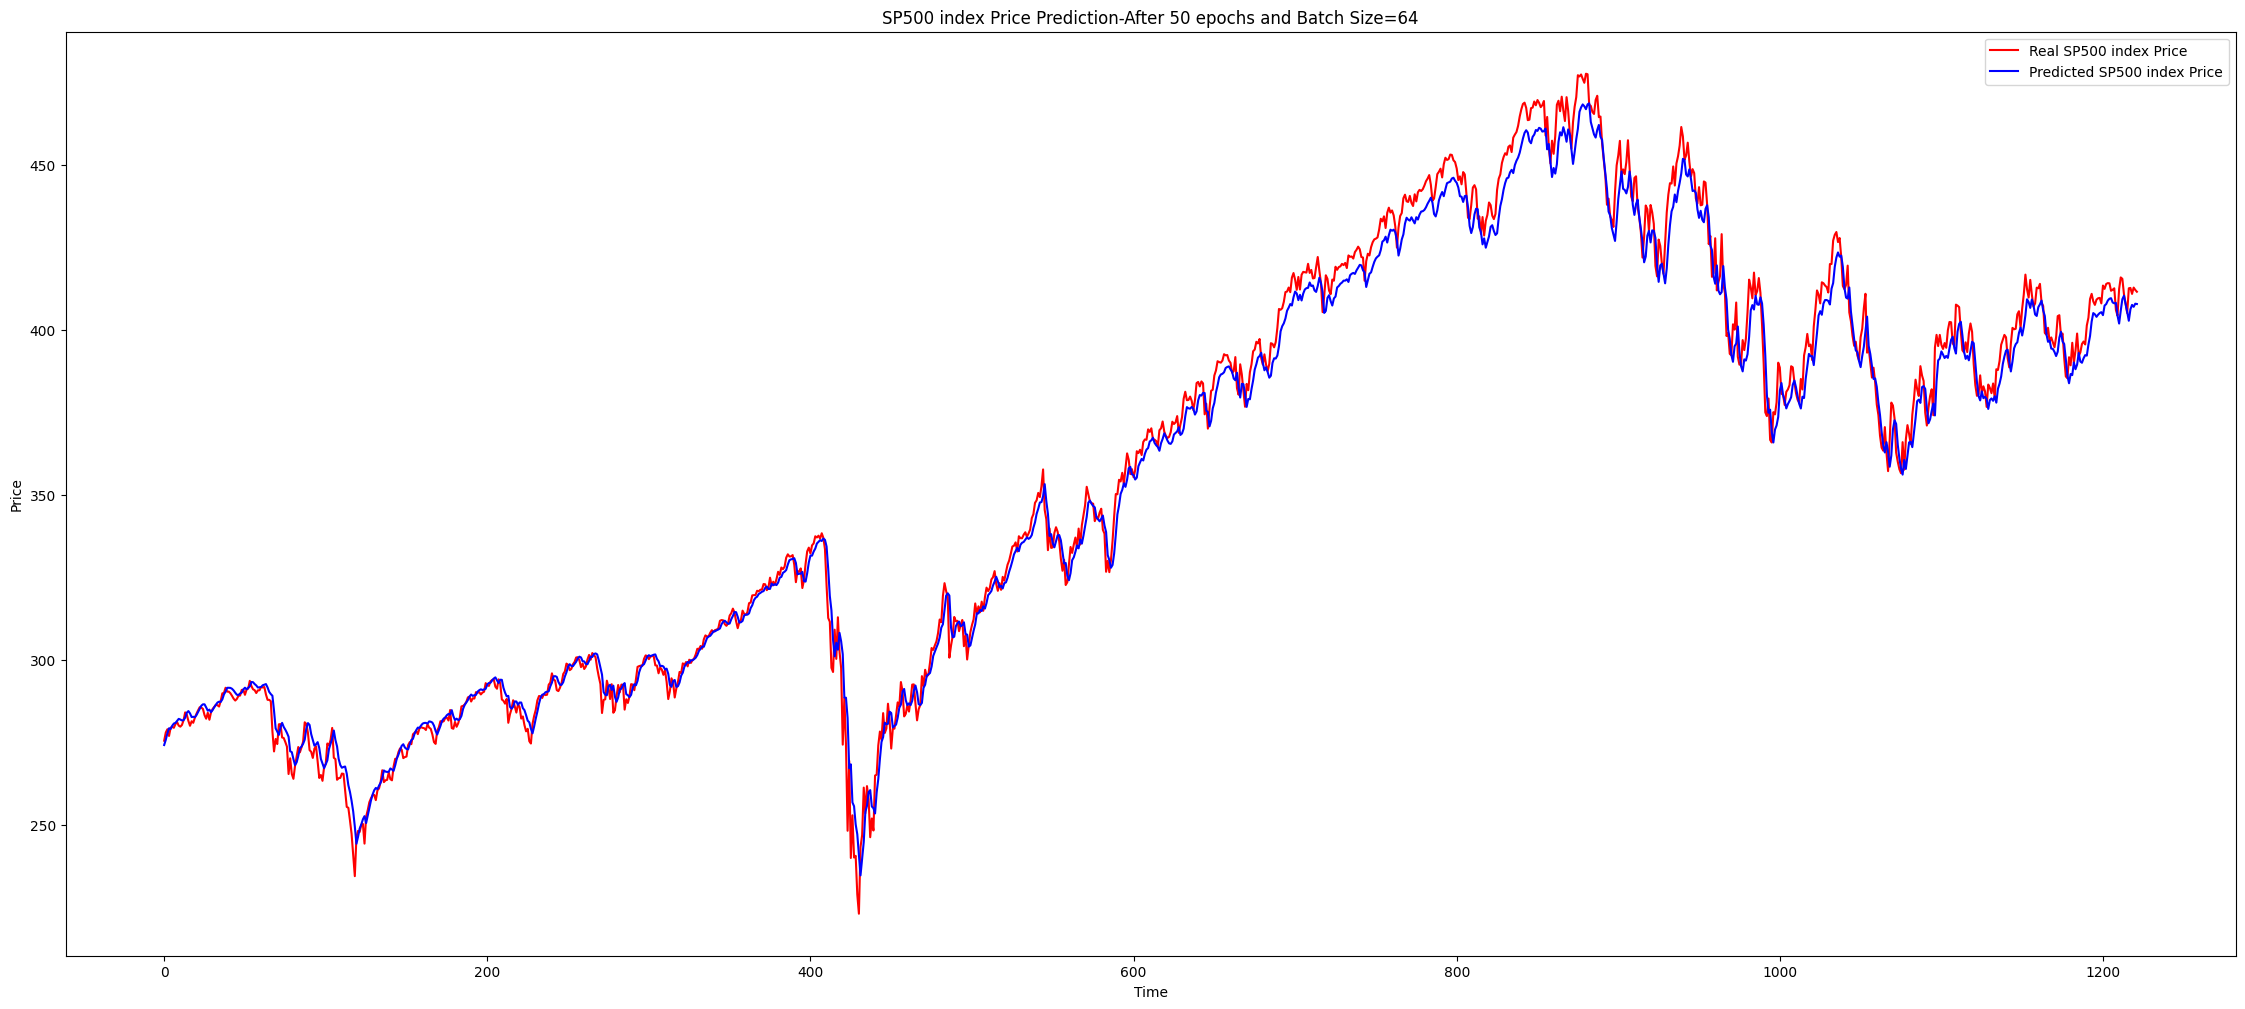

In [24]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(final_y_test, color = 'red', label = 'Real SP500 index Price')
plt.plot(final_y_pred, color = 'blue', label = 'Predicted SP500 index Price')
plt.title('SP500 index Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()